In [17]:
import numpy as np
from PIL import Image, ImageFont, ImageDraw
# import cv2
import sys

# normalize the image matrix
def toUINT(data):
    data-=data.min()
    data = 255.0*data/data.max()
    return data.astype(np.uint8)

# Convert RGB image to grayscale
def rgb2gray(img):
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    gray = 0.2126*R + 0.7152*G + 0.0722*B
    return toUINT(gray)

def showPhoto(ph, size =(8,8)):
    plt.figure(figsize=size)
    plt.imshow(ph, cmap = 'gray', interpolation='none')
    plt.show()
    
# Otsu binarization 
def binarizer(img):
    ret3,th3 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th3

# BUG: symbol "-" is not processed correctly in case of small font sizes
def getSymbols(font, height, symbols=np.array(["W", "@", "0", ".", "|", "\\", "/", "*"], dtype=np.str)):
    
    font = ImageFont.truetype(font, height)
    bitmaps = {}
    
    for i in range(len(symbols)):
        img = Image.new(mode="L", size=(3*height, height), color=255)
        draw = ImageDraw.Draw(img)
        draw.text((0, 0), 2*symbols[i], font=font)
        buf_S = np.array(img)
        
        n = ((buf_S == 255*np.ones((height,1))).sum(axis=0) == height).argmin() + 1
        
        while not np.array_equal(buf_S[:,:n], buf_S[:,n:2*n]):
            n += 1
        
        bitmaps[symbols[i]] = buf_S[:,:n]
        
    return bitmaps

def getImage(pic, mode="grayscale"):
    img = Image.open(pic)
    img = np.array(img)
    
    if mode == "grayscale":
        return rgb2gray(img)
    elif mode == "binary":
        return binarizer(img)

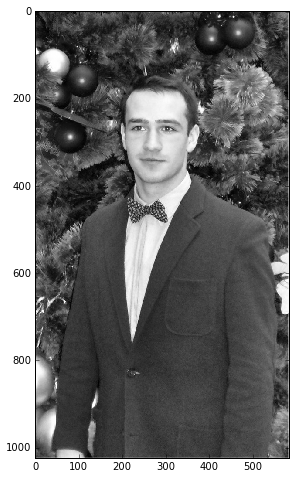

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

showPhoto(getImage("van9.jpg"))

In [19]:
symbol_height = 12

symbols = getSymbols("arial.ttf", symbol_height)
image = getImage("van9.jpg")

Cut the image to make its height to be divisible by symbols height. (**Useless in current implementation**)

In [20]:
rows_number = image.shape[0] / symbol_height
print image.shape
image = image[:rows_number*symbol_height, :]
print image.shape

(1024, 582)
(1020, 582)


In [25]:
cache = np.zeros((rows_number, image.shape[1]), int)
cache.fill(-1)
parent_symbol = np.zeros((rows_number, image.shape[1] + 1), str)
inf = sys.maxint

def loss(row, pos, symbol):
    image_part = image[row * symbol_height : (row + 1) * symbol_height, pos : pos + symbol.shape[1]]
    if image_part.shape != symbol.shape:
        return inf
    return np.linalg.norm(symbol - image_part)**2

def dp(row, pos):
    if pos == image.shape[1]:
        return 0
    
    if pos > image.shape[1]:
        return inf
    
    if cache[row, pos] != -1:
        return cache[row, pos]
    
    res = inf
    
    for symbol_key, symbol in symbols.iteritems():
        next_pos = pos + symbol.shape[1]
        cur_res = dp(row, next_pos) + loss(row, pos, symbol)
        if cur_res < res:
            res = cur_res
            parent_symbol[row, next_pos] = symbol_key
    
    cache[row, pos] = res
    return res

taken_symbols = []

for row in xrange(rows_number):
    parent_symbol.fill('')
    dp(row, 0)
    cur_symbols = []
    pos = image.shape[1]
    while parent_symbol[row, pos] != '':
        cur_symbols.append(parent_symbol[row, pos])
        pos -= symbols[parent_symbol[row, pos]].shape[1]
    taken_symbols.append(cur_symbols)

In [35]:
# print "len(taken_symbols) =", len(taken_symbols)
# print taken_symbols[0]
# print taken_symbols[1]

for row in xrange(rows_number):
    print ''.join(taken_symbols[row])

W@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@W@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
W@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
W@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@W@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
W@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@W@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
W@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
W@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
W@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@0
@@W@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
W@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@0
W@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
W@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
W@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
W@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
W@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@0
@@@@@@W@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@W@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@W@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@0
@@@@@@@@@@@@W@@@